In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import jieba as jb
import re
import time

import torch
import torch.nn as nn
from torchnlp.encoders.text import StaticTokenizerEncoder
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.autograd import Variable
from torch.optim import Adam

from itertools import repeat

from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("dataset.csv", encoding="gb18030")
df = df[['cat', 'keyword']]

In [3]:
print("数据总量: %d ." % len(df))
print("在 cat 列中总共有 %d 个空值." % df['cat'].isnull().sum())
print("在 keyword 列中总共有 %d 个空值." % df['keyword'].isnull().sum())

数据总量: 16953 .
在 cat 列中总共有 0 个空值.
在 keyword 列中总共有 0 个空值.


    cat  count
0    经济   3983
1  工业技术   3834
2    医药   3250
3  农业科学   3131
4  天文地理   2755


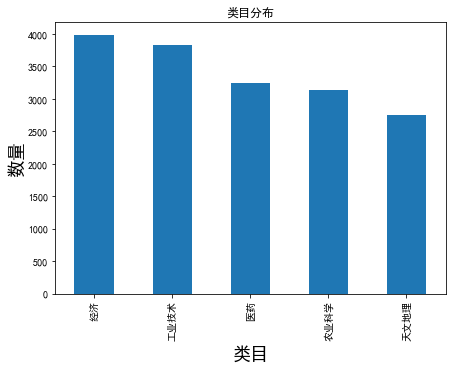

In [4]:
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
data_count = df['cat'].value_counts()
data_count_kw = {'cat':data_count.index, 'count':data_count}
df_cat = pd.DataFrame(data=data_count_kw).reset_index(drop=True)
print(df_cat)
df_cat.plot(x='cat', y='count', kind='bar', legend=False,  figsize=(7, 5))
plt.title(u"类目分布")
plt.ylabel(u'数量', fontsize=18)
plt.xlabel(u'类目', fontsize=18)
plt.show()

In [5]:
df['cat_id'] = df['cat'].factorize()[0]

cat_id_df = df[['cat', 'cat_id']].drop_duplicates().sort_values('cat_id').reset_index(drop=True)

cat_to_id = dict(cat_id_df.values)
id_to_cat = dict(cat_id_df[['cat_id', 'cat']].values)

print(cat_id_df)

    cat  cat_id
0  工业技术       0
1    经济       1
2  天文地理       2
3    医药       3
4  农业科学       4


In [6]:
# 定义删除除字母,数字，汉字以外的所有符号的函数
def remove_punctuation(line):
    line = str(line)
    if line.strip() == '':
        return ''
    rule = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5]")
    line = rule.sub('', line)
    return line

def stopwordslist(filepath):
    stopwords = [line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()]
    return stopwords

# 加载停用词
stopwords = stopwordslist("chineseStopWords.txt")

# 删除除字母,数字，汉字以外的所有符号
df['clean_keyword'] = df['keyword'].apply(remove_punctuation)
print(df.sample(10))

# 分词，并过滤停用词
df['cut_keyword'] = df['clean_keyword'].apply(lambda x: " ".join([w for w in list(jb.cut(x)) if w not in stopwords]))
print(df.head())

        cat                                            keyword  cat_id  \
127    工业技术  无线携能传输协同中继非正交多址接入系统的 速率优化设计,非正交多址接入系统,无线携能传输,速...       0   
13719  工业技术                                   远程终端可控AI门禁系统,,,,       0   
4775   农业科学                           2019年全球农药市场状况与主要特点分析,,,,       4   
5518   天文地理    基于对流参数南宁地区雷暴天气潜势预报方法研究,雷达回波,强对流天气,时空分布特征,短时预报指标       2   
2295     医药  陕西省住院新生儿出生胎龄＜34周早产儿院内感染败血症多中心流行病学调查,婴儿,早产,败血症,...       3   
16623    经济                     乡村振兴该从何入手,乡村振兴战略,内生动力,农业农村现代化,       1   
14075  工业技术                  操作系统发展趋势分析与开源发展建议,操作系统,开源,一体化,虚拟化       0   
12356  农业科学                   家禽感染肠道疾病的影响因素及危害,家禽,肠道疾病,产气荚膜梭菌,       4   
13598  农业科学               粳稻农艺性状与品质性状间的遗传相关性,粳稻,农艺性状,穗部性状,品质性状       4   
16473    经济  劳动力老龄化阻碍了农业生产吗?——基于空间计量模型的实证分析,农业劳动力老龄化,农业生产,区...       1   

                                           clean_keyword  
127    无线携能传输协同中继非正交多址接入系统的速率优化设计非正交多址接入系统无线携能传输速率优化功率分配  
13719                                       远程终端可控AI门禁系统  
4775    

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\塃狩烨崎\AppData\Local\Temp\jieba.cache
Loading model cost 0.691 seconds.
Prefix dict has been built successfully.


    cat                                    keyword  cat_id  \
0  工业技术  电熔耐火材料工艺除尘设置及其除尘技术的研究,电熔耐火材料,工艺,除尘技术,布袋除尘       0   
1  工业技术  基于纳秒激光加工技术的表面织构工艺参数研究,纳秒激光表面织构,表面润湿性,表面能,       0   
2  工业技术           化工机械设备安装工艺技术探究,化工机械设备,安装工艺,技术,方法       0   
3  工业技术              热法磷酸生产磷酸脲的工艺技术研究,磷酸脲,热法磷酸,尿素,       0   
4  工业技术  矿用主通信线缆组件制作工艺关键技术研究,主通信线缆组件,制作工艺,关键技术,可靠性       0   

                           clean_keyword  \
0  电熔耐火材料工艺除尘设置及其除尘技术的研究电熔耐火材料工艺除尘技术布袋除尘   
1  基于纳秒激光加工技术的表面织构工艺参数研究纳秒激光表面织构表面润湿性表面能   
2           化工机械设备安装工艺技术探究化工机械设备安装工艺技术方法   
3              热法磷酸生产磷酸脲的工艺技术研究磷酸脲热法磷酸尿素   
4  矿用主通信线缆组件制作工艺关键技术研究主通信线缆组件制作工艺关键技术可靠性   

                                         cut_keyword  
0   电熔 耐火材料 工艺 除尘 设置 除尘 技术 研究 电熔 耐火材料 工艺 除尘 技术 布袋 除尘  
1   纳秒 激光 加工 技术 表面 织构 工艺 参数 研究 纳秒 激光 表面 织构 表面 润湿性 表面  
2              化工 机械设备 安装 工艺技术 探究 化工 机械设备 安装 工艺技术 方法  
3                热法 磷酸 生产 磷酸 脲 工艺技术 研究 磷酸 脲 热法 磷酸 尿素  
4  矿用 主 通信 线缆 组件 制作 工艺 关键技术 研究 主 通信 线缆 组件 制作 工艺 关...  


In [7]:
# 设置最频繁使用的30000个词
MAX_NB_WORDS = 30000

# 每条cut_keyword最大的长度50
MAX_SEQUENCE_LENGTH = 50

# 设置Embeddingceng层的维度
EMBEDDING_DIM = 128

tok = StaticTokenizerEncoder(sample=df['cut_keyword'].values, tokenize=lambda x: x.split()) # 初始化标注器

word_index = tok.token_to_index  # 查看对应的单词和数字的映射关系dict

#print(word_index)

X = [tok.encode(text) for text in df['cut_keyword'].values] # 通过texts_to_sequences 这个dict可以将每个string的每个词转成数字
X.append(torch.tensor([0 for i in range(MAX_SEQUENCE_LENGTH)]))

# print(pd.DataFrame(X))

X = pad_sequence(X).T[:-1]

print(X,X.shape)

tensor([[   5,    6,    7,  ...,    0,    0,    0],
        [  13,   14,   15,  ...,    0,    0,    0],
        [  20,   21,   22,  ...,    0,    0,    0],
        ...,
        [ 654, 1138, 2210,  ...,    0,    0,    0],
        [4584, 1265,  654,  ...,    0,    0,    0],
        [4442, 2083,  581,  ...,    0,    0,    0]]) torch.Size([16953, 50])


In [8]:
Y = df['cat_id'].values

print(type(Y),Y.shape)
print(type(X),X.shape)

X = np.array([[int(j) for j in i] for i in X])
Y = np.array(Y)

print(type(Y),Y.shape)
print(type(X),X.shape)

# 拆分训练集和测试集

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=42, shuffle=True)

print(X_train.shape, Y_train.shape)

print(X_test.shape, Y_test.shape)


<class 'numpy.ndarray'> (16953,)
<class 'torch.Tensor'> torch.Size([16953, 50])
<class 'numpy.ndarray'> (16953,)
<class 'numpy.ndarray'> (16953, 50)
(15257, 50) (15257,)
(1696, 50) (1696,)


In [9]:
Y_train

array([0, 4, 0, ..., 2, 3, 1], dtype=int64)

In [20]:

class pyt_SpatialDropout(nn.Module):
    """
    空间dropout，即在指定轴方向上进行dropout，常用于Embedding层和CNN层后
    如对于(batch, timesteps, embedding)的输入，若沿着axis=1则可对embedding的若干channel进行整体dropout
    若沿着axis=2则可对某些token进行整体dropout
    """
    def __init__(self, drop=0.5):
        super(pyt_SpatialDropout, self).__init__()
        self.drop = drop
        
    def forward(self, inputs, noise_shape=None):
        """
        @param: inputs, tensor
        @param: noise_shape, tuple, 应当与inputs的shape一致，其中值为1的即沿着drop的轴
        """
        outputs = inputs.clone()
        if noise_shape is None:
            noise_shape = (inputs.shape[0], *repeat(1, inputs.dim()-2), inputs.shape[-1])   # 默认沿着中间所有的shape
        
        self.noise_shape = noise_shape
        if not self.training or self.drop == 0:
            return inputs
        else:
            noises = self._make_noises(inputs)
            if self.drop == 1:
                noises.fill_(0.0)
            else:
                noises.bernoulli_(1 - self.drop).div_(1 - self.drop)
            noises = noises.expand_as(inputs)    
            outputs.mul_(noises)
            return outputs
            
    def _make_noises(self, inputs):
        return inputs.new().resize_(self.noise_shape)
    
    
class LSTMnet(nn.Module):
    def __init__(self, output_size, hidden_dim, bidirectional):
        super(LSTMnet, self).__init__()
        
        self.output_size = output_size
        
        self.Embedding = nn.Embedding(MAX_NB_WORDS, EMBEDDING_DIM)
        self.lstm = nn.LSTM(input_size=EMBEDDING_DIM, hidden_size=hidden_dim, dropout=0.2, bidirectional=bidirectional)
        self.dropout1 = nn.Dropout(0.25)
        self.linear1 = nn.Linear(EMBEDDING_DIM,64)
        self.dropout2 = nn.Dropout(0.3)
        self.linear2 = nn.Linear(64,output_size)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        
        batch_size = x.size()
        
        x = x.long()
        
        x = self.Embedding(x)
        lstm_out, hidden = self.lstm(x)
        
        out = self.dropout1(lstm_out)
        out = self.linear1(out)
        out = self.dropout2(out)
        out = self.linear2(out)
        
        sig_out = self.sig(out)
        sig_out = torch.max(out, 2)[1]
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:,-1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden

In [ ]:
# 训练模型

epochs = 3

batch_size = 1200

now_time = time.time()

model = LSTMnet(output_size=5,
                hidden_dim=128,
                bidirectional=False)

loss_function = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(),
                lr=0.001,
                betas=(0.9, 0.999),
                eps=1e-08,
                weight_decay=0,
                amsgrad=False)

reduce_lr = ReduceLROnPlateau(optimizer, 
                              mode='min', 
                              factor=0.2, 
                              patience=5, 
                              min_lr=0.001)


data = Variable(torch.Tensor(X_train))
target0 = Variable(torch.Tensor(Y_train))

target1 = torch.zeros(len(target),5)
index = target0.long().view(-1,1)
target = target1.scatter_(dim=1,index=index,value=1)

for epoch in range(epochs):
    output, hidden = model(data)
    
    
    output1 = torch.zeros(len(target),5)
    index = output.long().view(-1,1)
    output = output1.scatter_(dim=1,index=index,value=1)
    
    optimizer.zero_grad()
    loss = loss_function(output, target)
    loss = loss.requires_grad_()
    loss.backward()
    reduce_lr.step(loss)
    
    num_correct = torch.eq(output, target).sum().float().item()
    print(num_correct, len(target))
    print("Train Epoch: {}\t Loss: {:.6f}\t Acc: {:.6f}".format(epoch, loss.item(), (num_correct/len(target)-3)/2 ))


total_time = time.time() - now_time

print("total time is: ", total_time)

D:\software\Anaconda\lib\site-packages\torch\nn\modules\rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


52015.0 15257
Train Epoch: 0	 Loss: 1.700205	 Acc: 0.204627
52069.0 15257
Train Epoch: 1	 Loss: 1.698435	 Acc: 0.206397


In [24]:
output

tensor([[0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [26]:
target

tensor([[0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [27]:
target0

tensor([1., 2., 4.,  ..., 2., 2., 1.])

In [30]:
torch.eq(output, target)

tensor([[False,  True,  True,  True, False],
        [ True, False,  True,  True, False],
        [False, False,  True,  True,  True],
        ...,
        [False,  True, False,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True, False,  True, False,  True]])